In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

/Users/evansweeney/Desktop/492_project_local/cmse492_project/tornado/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Pre-Processing Weather Station Data
    1. Load in data
        1. Have a commented out section of code showing how to load in the data from there internet so that the instructor can just run that code
    2. Showing EDA for our weather station (to show what we might need to change)
        1. .transpose.describe() thing
        2.  Wind direction/speed graphs and such <- this is just above the other columns in terms of importance
        3. Same type of thing as this ^ but just all in the same cell / showing the many plots next to each other
    3. Reformatting (// showing the changes we are making also if applicable)
        1. Dropping certain columns
        2. Changing the time
        3. Filling in NaN values
            1. Forward/backward fill, not mean based for most columns
        4. Feature engineering <- for wind direction + wind speeds
        5. Other feature engineering if need be
    4. Frequency
    5. Scaling/ Normalizing the data
    6. Training and testing split of the data

## 1: Load in data
I am using hourly data from a single weather station in Kansas.

In [19]:
usc_station_path_2 = '/Users/evansweeney/Desktop/492_project_local/cmse492_project/data/raw/GHCNh_USW00013985_por.psv'
USW00013985 = pd.read_csv(usc_station_path_2, sep='|', low_memory=False)


In [23]:
# Define the useful columns
useful_columns = [
    'Year', 'Month', 'Day', 'Hour', 'Minute', 'Latitude', 'Longitude', 'Elevation',
    'temperature', 'dew_point_temperature', 'station_level_pressure', 'sea_level_pressure',
    'wind_direction', 'wind_speed', 'wind_gust', 'precipitation', 'relative_humidity', 'wet_bulb_temperature'
]

# Filter the original DataFrame in place for the years 2015 and 2016 and select the useful columns
USW00013985 = USW00013985[(USW00013985['Year'] == 2015) | (USW00013985['Year'] == 2016)][useful_columns]

# Display the modified original DataFrame
print(USW00013985)

        Year  Month  Day  Hour  Minute  Latitude  Longitude  Elevation  \
729150  2015      1    1     0       0   37.7608   -99.9689      814.1   
729151  2015      1    1     0      52   37.7608   -99.9689      814.1   
729152  2015      1    1     1      52   37.7608   -99.9689      814.1   
729153  2015      1    1     2      52   37.7608   -99.9689      814.1   
729154  2015      1    1     3       0   37.7608   -99.9689      814.1   
...      ...    ...  ...   ...     ...       ...        ...        ...   
757039  2016     12   31    20      52   37.7608   -99.9689      814.1   
757040  2016     12   31    21       0   37.7608   -99.9689      814.1   
757041  2016     12   31    21      52   37.7608   -99.9689      814.1   
757042  2016     12   31    22      52   37.7608   -99.9689      814.1   
757043  2016     12   31    23      52   37.7608   -99.9689      814.1   

        temperature  dew_point_temperature  station_level_pressure  \
729150        -10.6                  -16.

In [24]:
USW00013985.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,27894.0,2015.492256,4.999490e-01,2015.0000,2015.0000,2015.0000,2016.0000,2016.0000
Month,27894.0,6.511831,3.422975e+00,1.0000,4.0000,6.0000,9.0000,12.0000
Day,27894.0,15.895892,8.815512e+00,1.0000,8.0000,16.0000,24.0000,31.0000
Hour,27894.0,11.244569,6.803450e+00,0.0000,6.0000,11.0000,17.0000,23.0000
Minute,27894.0,37.315767,2.198999e+01,0.0000,14.0000,52.0000,52.0000,59.0000
Latitude,27894.0,37.760800,7.105555e-15,37.7608,37.7608,37.7608,37.7608,37.7608
Longitude,27894.0,-99.968900,0.000000e+00,-99.9689,-99.9689,-99.9689,-99.9689,-99.9689
Elevation,27894.0,814.100000,2.273778e-13,814.1000,814.1000,814.1000,814.1000,814.1000
temperature,27867.0,13.030624,1.113089e+01,-26.1000,4.4000,13.9000,21.1000,40.0000
dew_point_temperature,27867.0,5.513758,1.009862e+01,-28.9000,-2.8000,6.1000,14.4000,22.8000


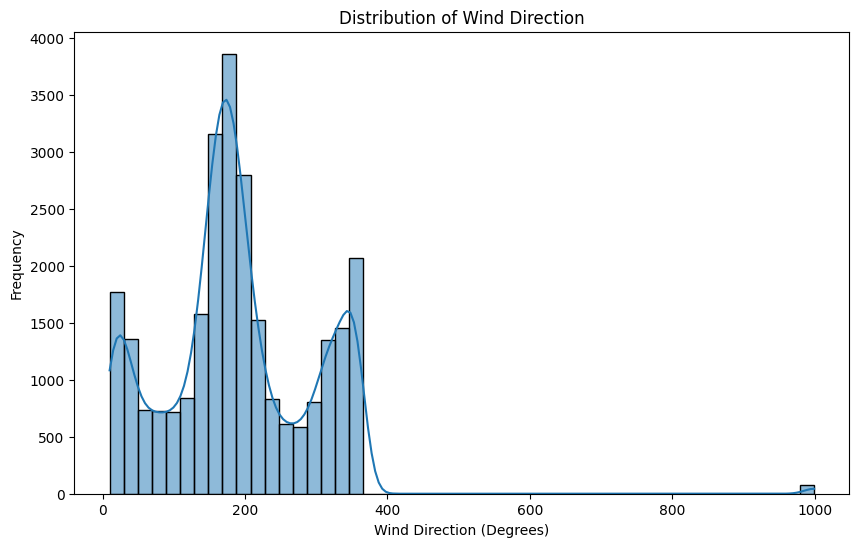

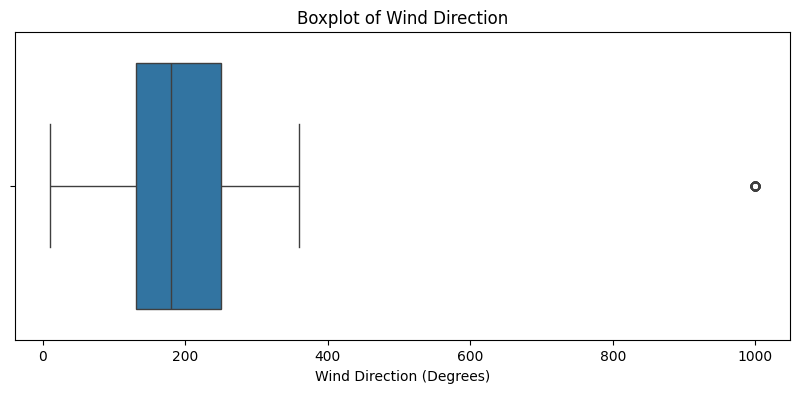

In [25]:
# Wind direction is not how we want it to be

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(USW00013985['wind_direction'], bins=50, kde=True)
plt.title('Distribution of Wind Direction')
plt.xlabel('Wind Direction (Degrees)')
plt.ylabel('Frequency')
plt.show()

# Boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x=USW00013985['wind_direction'])
plt.title('Boxplot of Wind Direction')
plt.xlabel('Wind Direction (Degrees)')
plt.show()

### Do we need to change other columns?

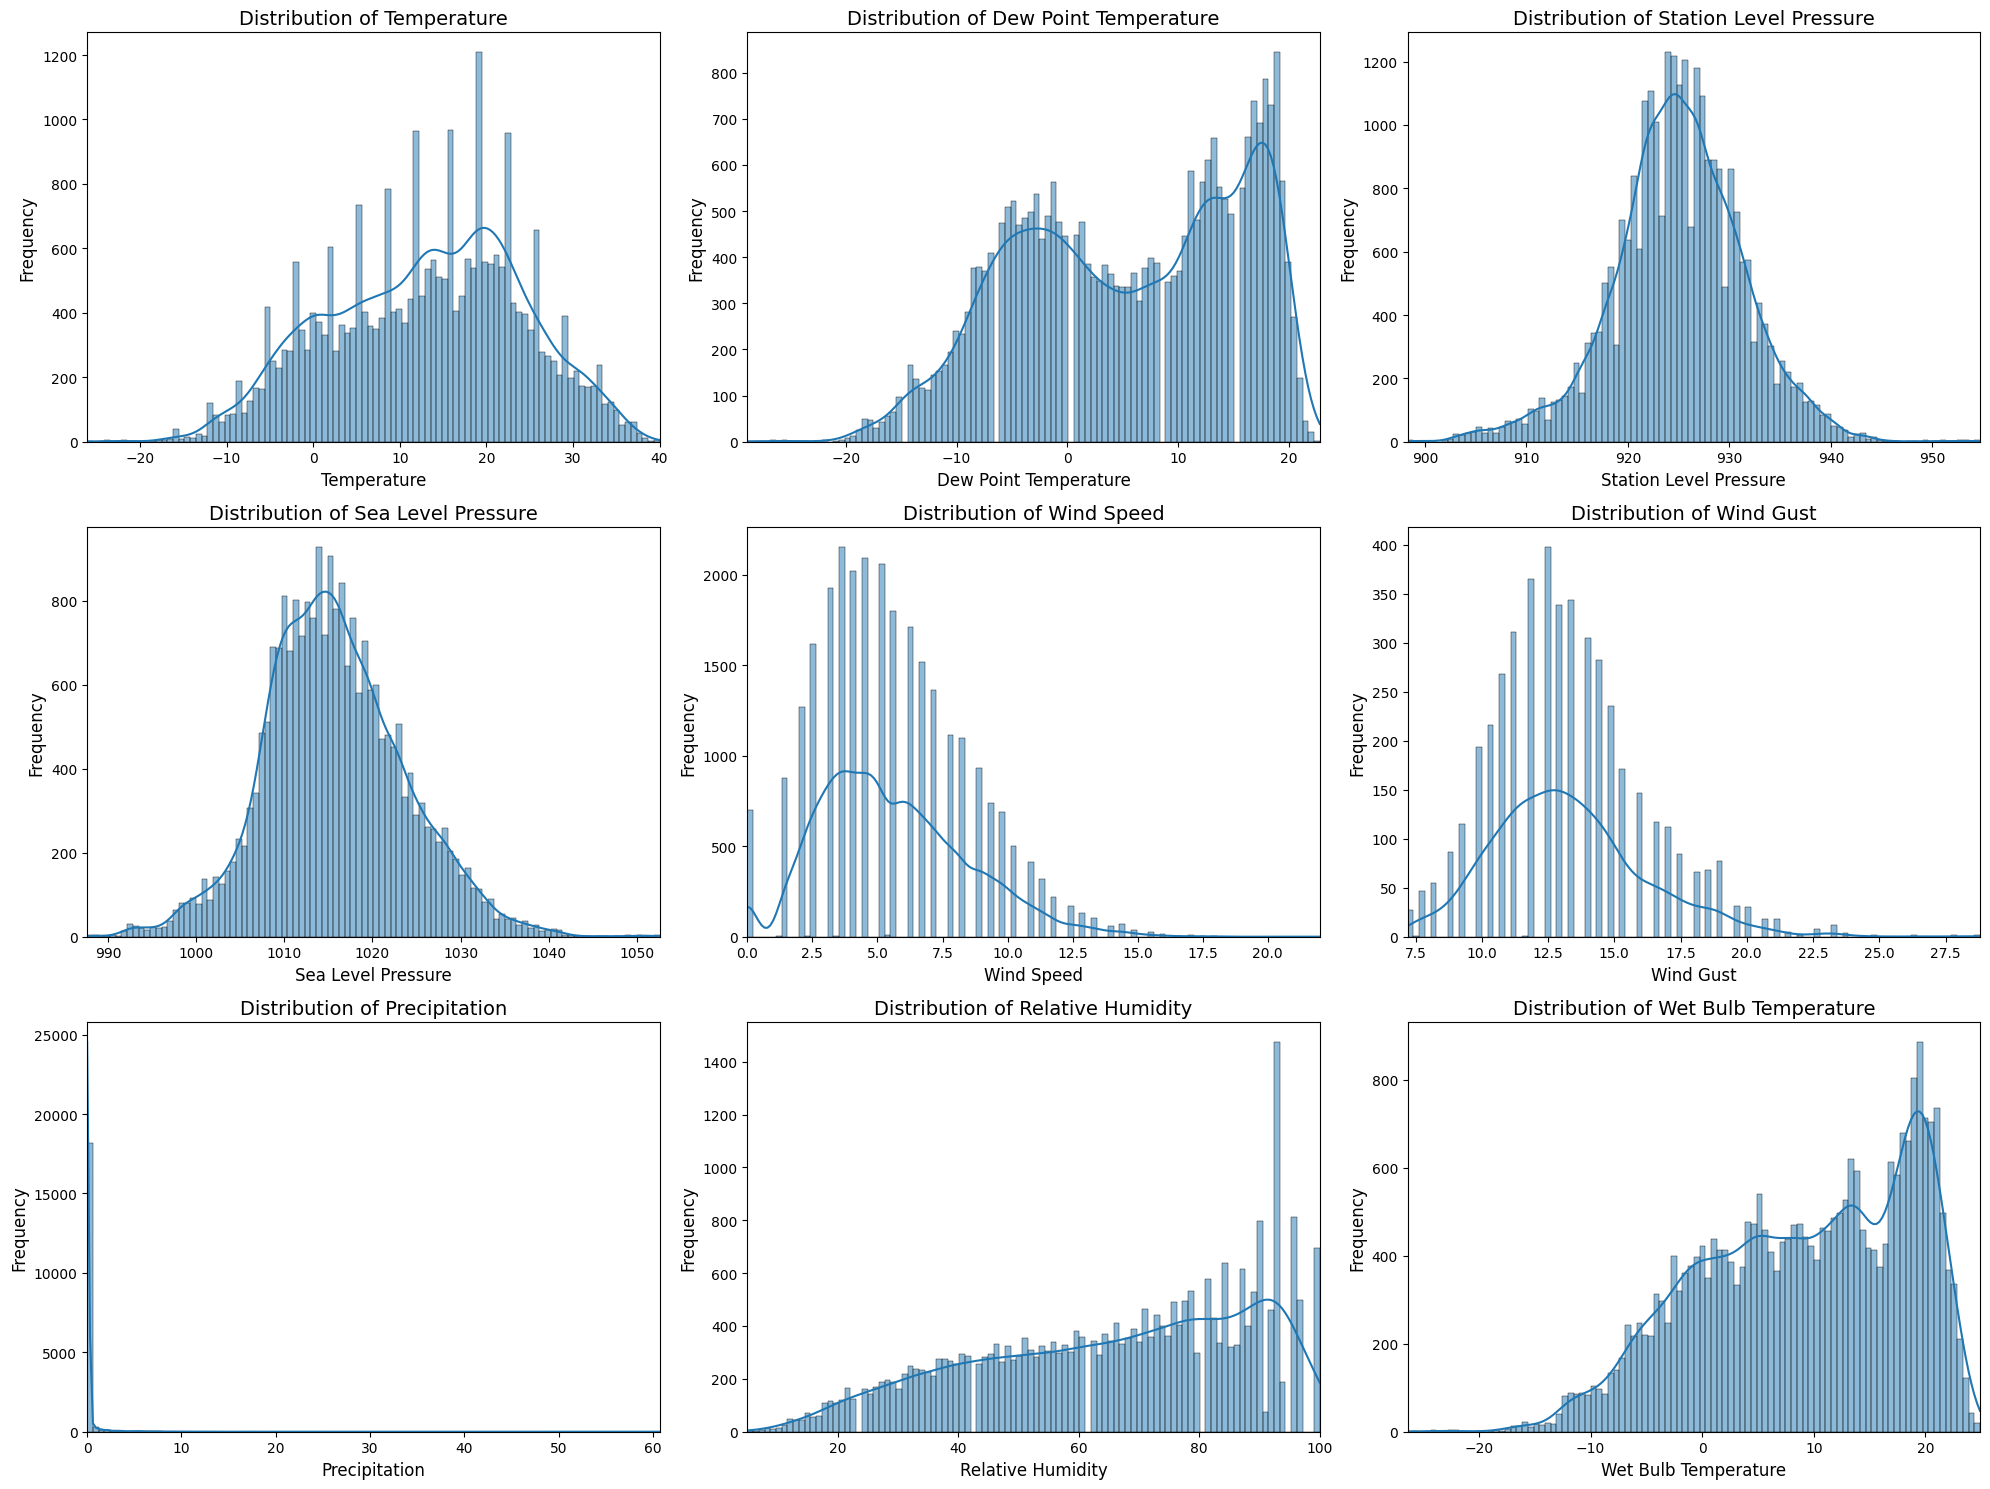

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to plot
columns_to_plot = [
    'temperature', 'dew_point_temperature', 'station_level_pressure', 'sea_level_pressure',
    'wind_speed', 'wind_gust', 'precipitation', 'relative_humidity', 'wet_bulb_temperature'
]

# Set up the matplotlib figure with a grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axes = axes.flatten()  # Flatten the array of axes for easy indexing

# Loop over the columns and create a histogram for each
for idx, col in enumerate(columns_to_plot):
    sns.histplot(data=USW00013985, x=col, bins=100, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col.replace("_", " ").title()}', fontsize=14)
    axes[idx].set_xlabel(col.replace("_", " ").title(), fontsize=12)
    axes[idx].set_ylabel('Frequency', fontsize=12)
    axes[idx].tick_params(axis='both', which='major', labelsize=10)
    # Ensure all data is visible, including outliers
    axes[idx].set_xlim(USW00013985[col].min(), USW00013985[col].max())

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


# Feature Engineering and Reformatting 

In [27]:
USW00013985['Datetime'] = pd.to_datetime(USW00013985[['Year', 'Month', 'Day', 'Hour', 'Minute']])
print(USW00013985[['Year', 'Month', 'Day', 'Hour', 'Minute', 'Datetime']].tail())

        Year  Month  Day  Hour  Minute            Datetime
757039  2016     12   31    20      52 2016-12-31 20:52:00
757040  2016     12   31    21       0 2016-12-31 21:00:00
757041  2016     12   31    21      52 2016-12-31 21:52:00
757042  2016     12   31    22      52 2016-12-31 22:52:00
757043  2016     12   31    23      52 2016-12-31 23:52:00


In [28]:
USW00013985.drop(['Latitude', 'Longitude', 'Elevation', 'Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)
print(USW00013985.tail())
# Only run this cell once!

        temperature  dew_point_temperature  station_level_pressure  \
757039         15.6                   -8.3                   920.2   
757040         15.6                   -8.3                   920.4   
757041          NaN                    NaN                   920.8   
757042          NaN                    NaN                   920.8   
757043          1.1                   -8.9                   920.8   

        sea_level_pressure  wind_direction  wind_speed  wind_gust  \
757039              1011.7            30.0         5.1        NaN   
757040              1011.7            30.0         5.1        NaN   
757041                 NaN            70.0         2.6        NaN   
757042                 NaN           100.0         1.5        NaN   
757043              1013.7           130.0         2.6        NaN   

        precipitation  relative_humidity  wet_bulb_temperature  \
757039            0.0               19.0                   5.7   
757040            NaN           

/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_2802/1976030561.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  USW00013985_hourly = USW00013985.resample('H').mean()


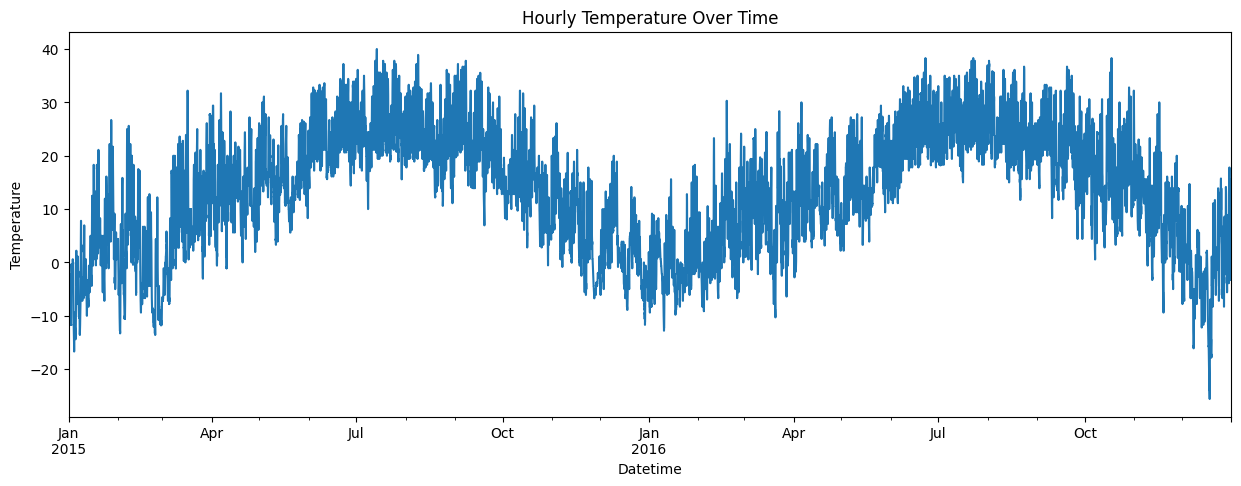

In [43]:
USW00013985 = USW00013985.set_index('Datetime')

USW00013985_hourly = USW00013985.resample('H').mean()

USW00013985_hourly = USW00013985_hourly.interpolate(method='time')

USW00013985_hourly['temperature'].plot(figsize=(15, 5))
plt.title('Hourly Temperature Over Time')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.show()


### Fixing wind direction

In [29]:
# Display unique values and count of missing values
print("Unique Wind Direction Values:", USW00013985['wind_direction'].unique())
print("Number of Missing Values:", USW00013985['wind_direction'].isnull().sum())

# Check for negative values or values exceeding 360
invalid_high = USW00013985[USW00013985['wind_direction'] > 360]
invalid_low = USW00013985[USW00013985['wind_direction'] < 0]
print(f"Number of wind_direction > 360: {invalid_high.shape[0]}")
print(f"Number of wind_direction < 0: {invalid_low.shape[0]}")

Unique Wind Direction Values: [260. 240. 230. 250. 270. 280. 200. 220. 290. 310. 210. 330.  nan 320.
 190. 300. 340. 350. 360. 140. 130. 120. 150. 160. 170. 180.  20.  30.
 999.  40.  10. 110.  90.  50.  60. 100.  80.  70.]
Number of Missing Values: 1020
Number of wind_direction > 360: 77
Number of wind_direction < 0: 0


In [44]:
# 1. Replace invalid 'wind_direction' values with NaN
USW00013985['wind_direction'].replace(999, np.nan, inplace=True)

# 2. Interpolate 'wind_speed'
USW00013985['wind_speed'] = USW00013985['wind_speed'].interpolate(method='time')

# 3. Convert 'wind_direction' to radians
USW00013985['wind_direction_rad'] = np.deg2rad(USW00013985['wind_direction'])

# 4. Calculate sine and cosine components
USW00013985['wind_dir_sin'] = np.sin(USW00013985['wind_direction_rad'])
USW00013985['wind_dir_cos'] = np.cos(USW00013985['wind_direction_rad'])

# 5. Interpolate sine and cosine components
USW00013985['wind_dir_sin'] = USW00013985['wind_dir_sin'].interpolate(method='time')
USW00013985['wind_dir_cos'] = USW00013985['wind_dir_cos'].interpolate(method='time')

# 6. Reconstruct wind direction from interpolated components
USW00013985['wind_direction_rad'] = np.arctan2(
    USW00013985['wind_dir_sin'], USW00013985['wind_dir_cos']
)

# 7. Convert radians back to degrees
USW00013985['wind_direction'] = np.rad2deg(USW00013985['wind_direction_rad']) % 360

# 8. Compute wind x and y components
USW00013985['Wx'] = USW00013985['wind_speed'] * np.cos(USW00013985['wind_direction_rad'])
USW00013985['Wy'] = USW00013985['wind_speed'] * np.sin(USW00013985['wind_direction_rad'])

# 9. Drop intermediate columns
USW00013985.drop(['wind_dir_sin', 'wind_dir_cos', 'wind_direction_rad'], axis=1, inplace=True)


/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_2802/4262654532.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  USW00013985['wind_direction'].replace(999, np.nan, inplace=True)


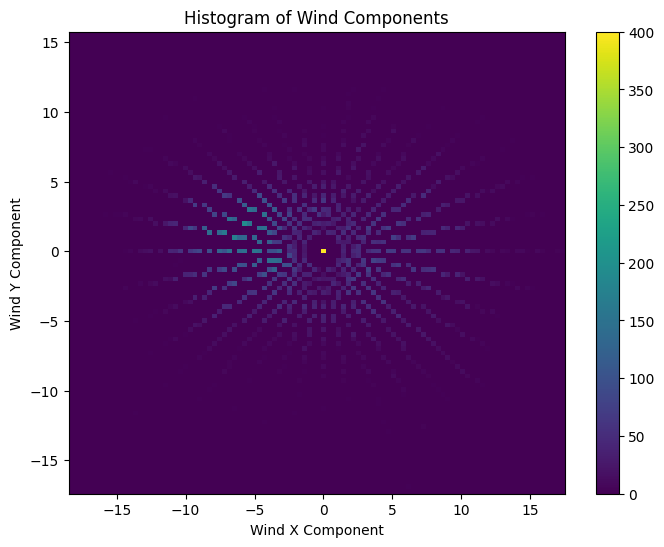

In [55]:
plt.figure(figsize=(8, 6))
plt.hist2d(USW00013985['Wx'], USW00013985['Wy'], bins=(100, 100), vmax=400)
plt.colorbar()
plt.xlabel('Wind X Component')
plt.ylabel('Wind Y Component')
plt.title('Histogram of Wind Components')
plt.show()


In [46]:
print("Number of Missing Values:", USW00013985['wind_direction'].isnull().sum())
print("Number of Missing Values:", USW00013985['wind_speed'].isnull().sum())

Number of Missing Values: 0
Number of Missing Values: 0


In [48]:
import pandas as pd

# Assuming USW00013985 DataFrame is already loaded.
# If not, you can load it using pd.read_csv, pd.read_excel, etc.
# Example:
# USW00013985 = pd.read_csv('your_file.csv')

# 1. Print the shape of the DataFrame
df_shape = USW00013985.shape
print(f"DataFrame Shape: {df_shape[0]} rows, {df_shape[1]} columns\n")

# 2. Define the list of columns to check for missing entries
columns_to_check = [
    'temperature',
    'dew_point_temperature',
    'station_level_pressure',
    'sea_level_pressure',
    'wind_direction',
    'wind_speed',
    'wind_gust',
    'precipitation',
    'relative_humidity',
    'wet_bulb_temperature',
]

# Verify that all specified columns exist in the DataFrame
missing_columns = [col for col in columns_to_check if col not in USW00013985.columns]
if missing_columns:
    print("Warning: The following columns are not in the DataFrame and will be skipped:")
    for col in missing_columns:
        print(f" - {col}")
    # Remove missing columns from the list to prevent errors
    columns_to_check = [col for col in columns_to_check if col in USW00013985.columns]

# 3. Calculate the number of missing entries for each specified column
missing_counts = USW00013985[columns_to_check].isnull().sum()

# 4. Print the missing counts in a readable format
print("Missing Entries per Column:")
for column, count in missing_counts.items():
    print(f" - {column}: {count} missing entries")



DataFrame Shape: 27894 rows, 12 columns

Missing Entries per Column:
 - temperature: 27 missing entries
 - dew_point_temperature: 27 missing entries
 - station_level_pressure: 52 missing entries
 - sea_level_pressure: 4618 missing entries
 - wind_direction: 0 missing entries
 - wind_speed: 0 missing entries
 - wind_gust: 23326 missing entries
 - precipitation: 8804 missing entries
 - relative_humidity: 27 missing entries
 - wet_bulb_temperature: 65 missing entries


In [57]:
variables_to_interpolate = ['temperature', 'dew_point_temperature', 'station_level_pressure', 
                            'sea_level_pressure', 'relative_humidity', 'wet_bulb_temperature']

for var in variables_to_interpolate:
    USW00013985[var] = USW00013985[var].interpolate(method='time')

USW00013985['wind_gust'].fillna(0, inplace=True)
USW00013985['precipitation'].fillna(0, inplace=True) 

print(USW00013985.isnull().sum())

temperature               0
dew_point_temperature     0
station_level_pressure    0
sea_level_pressure        0
wind_direction            0
wind_speed                0
wind_gust                 0
precipitation             0
relative_humidity         0
wet_bulb_temperature      0
Wx                        0
Wy                        0
dtype: int64


/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_2802/1481682164.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  USW00013985['wind_gust'].fillna(0, inplace=True)
/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_2802/1481682164.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

# Frequency

In [94]:
# Calculate time differences between consecutive observations
time_diffs = USW00013985.index.to_series().diff().dropna()

# Display the full output
print(time_diffs.value_counts().sort_index().tail(20))

Datetime
0 days 00:42:00       57
0 days 00:43:00       49
0 days 00:44:00       56
0 days 00:45:00       58
0 days 00:46:00       41
0 days 00:47:00       58
0 days 00:48:00       38
0 days 00:49:00       40
0 days 00:50:00       82
0 days 00:51:00       37
0 days 00:52:00     5114
0 days 00:53:00       51
0 days 00:54:00        3
0 days 00:55:00       23
0 days 00:56:00       18
0 days 00:57:00       16
0 days 00:58:00       98
0 days 01:00:00    10224
0 days 01:02:00        1
0 days 02:00:00        1
Name: count, dtype: int64


In [102]:
# Resample to hourly frequency using the mean
USW00013985_hourly = USW00013985.resample('H').mean()
print(USW00013985_hourly.isnull().sum())
print(len(USW00013985_hourly))
print(len(USW00013985))

temperature               1
dew_point_temperature     1
station_level_pressure    1
sea_level_pressure        1
wind_direction            1
wind_speed                1
wind_gust                 1
precipitation             1
relative_humidity         1
wet_bulb_temperature      1
Wx                        1
Wy                        1
Day sin                   1
Day cos                   1
Year sin                  1
Year cos                  1
dtype: int64
17544
27894


/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_2802/3756293373.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  USW00013985_hourly = USW00013985.resample('H').mean()


In [112]:
# Filter specific time range for selected columns
missing_entries = USW00013985_hourly.loc['2015-06-02 13:00:00':'2015-06-02 15:00:00', 
                                      ['temperature', 'dew_point_temperature', 'Wy', 'Wx']]

print(missing_entries)

# Check the original data around the missing time window
# Filter specific time range for selected columns
missing_time_window = USW00013985.loc['2015-06-02 13:00:00':'2015-06-02 15:00:00', 
                                      ['temperature', 'dew_point_temperature', 'Wy', 'Wx']]

print(missing_time_window)


                     temperature  dew_point_temperature        Wy        Wx
Datetime                                                                   
2015-06-02 13:00:00        19.45                  16.95  0.581721 -6.899106
2015-06-02 14:00:00          NaN                    NaN       NaN       NaN
2015-06-02 15:00:00        24.40                  17.20 -1.163443 -6.598212
                     temperature  dew_point_temperature            Wy  \
Datetime                                                                
2015-06-02 13:29:00         18.9                   16.7  8.817457e-16   
2015-06-02 13:52:00         20.0                   17.2  1.163443e+00   

                           Wx  
Datetime                       
2015-06-02 13:29:00 -7.200000  
2015-06-02 13:52:00 -6.598212  


In [114]:
USW00013985_hourly = USW00013985_hourly.interpolate(method='time')
missing_entries_2 = USW00013985_hourly.loc['2015-06-02 13:00:00':'2015-06-02 15:00:00', 
                                      ['temperature', 'dew_point_temperature', 'Wy', 'Wx']]
print(missing_entries_2)

                     temperature  dew_point_temperature        Wy        Wx
Datetime                                                                   
2015-06-02 13:00:00       19.450                 16.950  0.581721 -6.899106
2015-06-02 14:00:00       21.925                 17.075 -0.290861 -6.748659
2015-06-02 15:00:00       24.400                 17.200 -1.163443 -6.598212


In [119]:
# Convert DatetimeIndex to UNIX timestamp in seconds
timestamp_s = USW00013985_hourly.index.map(pd.Timestamp.timestamp)

In [122]:
# Number of seconds in a day and a year
day = 24 * 60 * 60  # Seconds in a day
year = 365.2425 * day  # Average seconds in a year (accounting for leap years)
# Add time-based features to the DataFrame
USW00013985_hourly['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
USW00013985_hourly['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
USW00013985_hourly['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
USW00013985_hourly['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
print(USW00013985_hourly[['Day sin', 'Day cos', 'Year sin', 'Year cos']].head())


                          Day sin   Day cos  Year sin  Year cos
Datetime                                                       
2015-01-01 00:00:00  1.232357e-12  1.000000  0.001505  0.999999
2015-01-01 01:00:00  2.588190e-01  0.965926  0.002222  0.999998
2015-01-01 02:00:00  5.000000e-01  0.866025  0.002939  0.999996
2015-01-01 03:00:00  7.071068e-01  0.707107  0.003656  0.999993
2015-01-01 04:00:00  8.660254e-01  0.500000  0.004372  0.999990


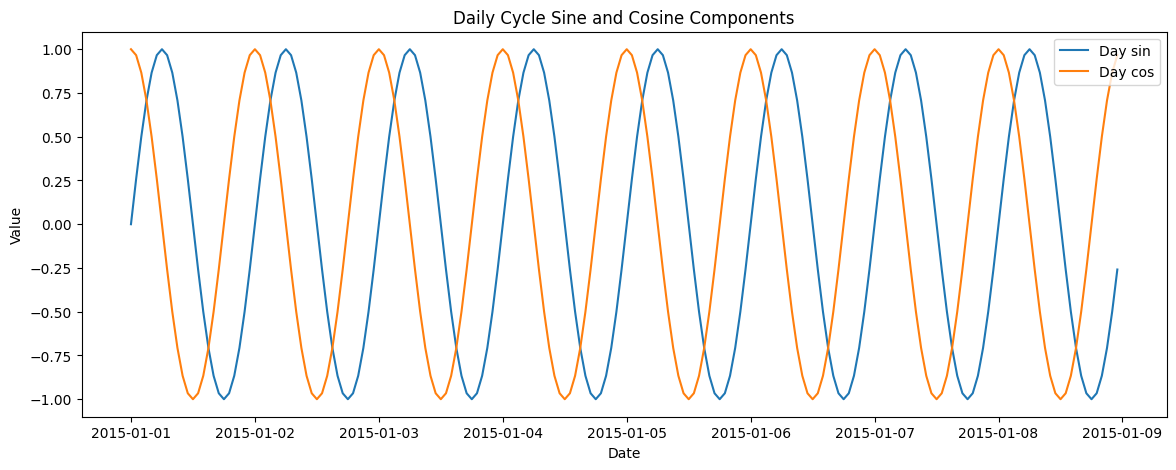

In [123]:
import matplotlib.pyplot as plt

# Overlaying the Day sin and Day cos over a selected week
subset = USW00013985_hourly.loc['2015-01-01' : '2015-01-08']

plt.figure(figsize=(14, 5))
plt.plot(subset.index, subset['Day sin'], label='Day sin')
plt.plot(subset.index, subset['Day cos'], label='Day cos')
plt.title('Daily Cycle Sine and Cosine Components')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


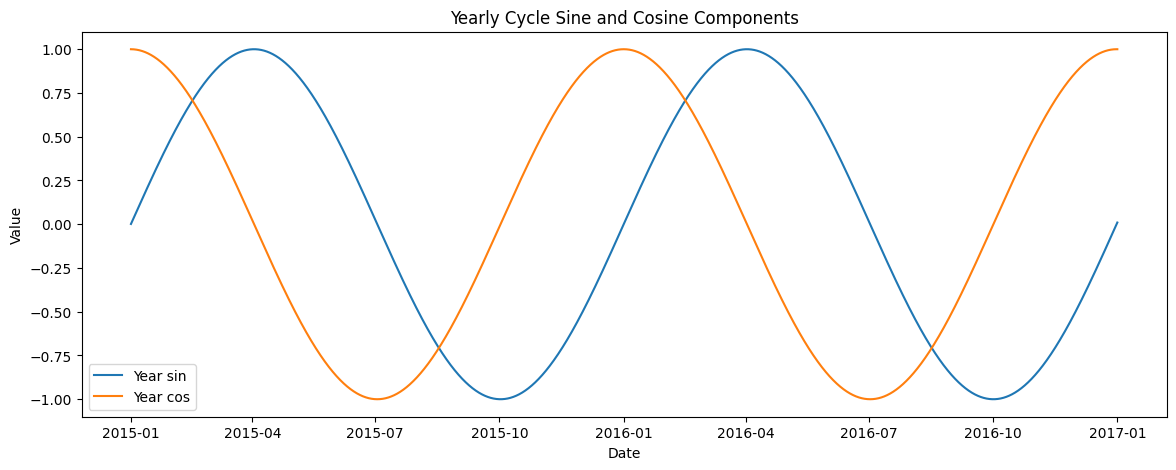

In [124]:
# Select a year's data
subset = USW00013985_hourly.loc['2015-01-01' : '2016-12-31']

plt.figure(figsize=(14, 5))
plt.plot(subset.index, subset['Year sin'], label='Year sin')
plt.plot(subset.index, subset['Year cos'], label='Year cos')
plt.title('Yearly Cycle Sine and Cosine Components')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [125]:
# Number of samples
# Extract the temperature data
temperature = USW00013985_hourly['temperature'].dropna()

# Number of samples
n_samples = len(temperature)

# Sampling rate (samples per hour)
sampling_rate = 1  # Assuming hourly data

# Compute the FFT of the temperature data
fft_vals = np.fft.rfft(temperature)

# Frequencies associated with the FFT components
freqs = np.fft.rfftfreq(n_samples, d=1/sampling_rate)

# Convert frequencies to cycles per year
hours_per_year = 24 * 365.2425
freqs_per_year = freqs * sampling_rate * (hours_per_year / n_samples)



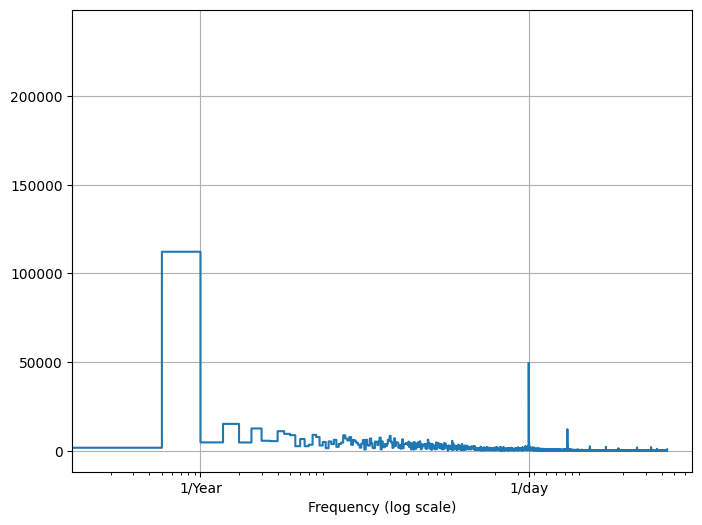

In [127]:
fft = tf.signal.rfft(USW00013985_hourly['temperature'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(USW00013985_hourly['temperature'])
hours_per_year = 24*365.5 # 2016 is a leap year, only using 2015, 2016
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
plt.xlabel('Frequency (log scale)')
plt.grid(True)
plt.show()

# Split the data

In [128]:
# Let's assume your processed DataFrame is called 'USW00013985_hourly'
df = USW00013985_hourly.copy()
# Sort the DataFrame by datetime index
df = df.sort_index()


In [129]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [130]:
print(f"Total samples: {n}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")


Total samples: 17544
Training samples: 12280
Validation samples: 3509
Test samples: 1755


In [131]:
num_features = df.shape[1]
print(f"Number of features: {num_features}")


Number of features: 16


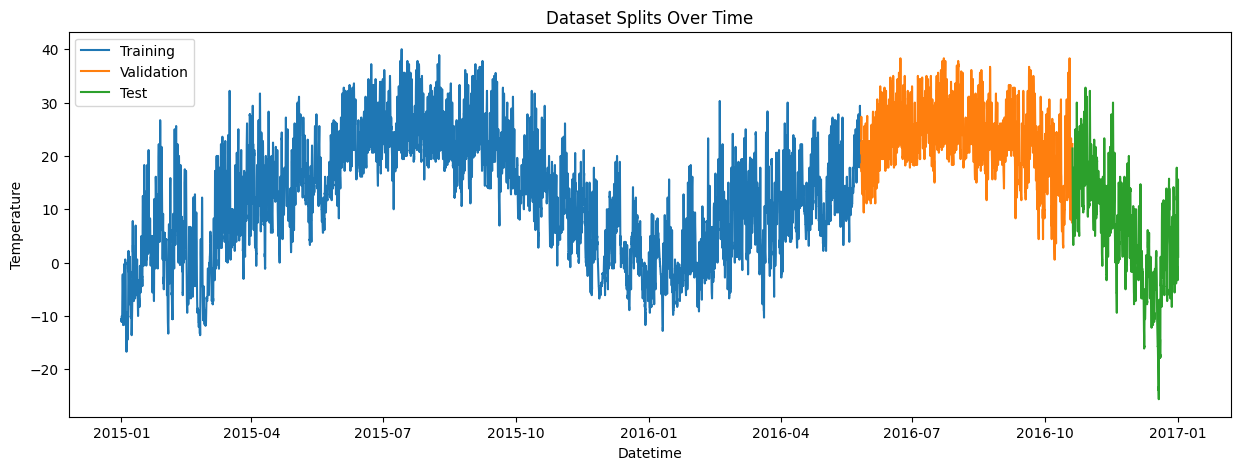

In [132]:
import matplotlib.pyplot as plt

# Plot an example feature over time, highlighting the splits
plt.figure(figsize=(15, 5))
plt.plot(train_df.index, train_df['temperature'], label='Training')
plt.plot(val_df.index, val_df['temperature'], label='Validation')
plt.plot(test_df.index, test_df['temperature'], label='Test')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.legend()
plt.title('Dataset Splits Over Time')
plt.show()


# Normalize the data

In [133]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_2802/3214313372.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


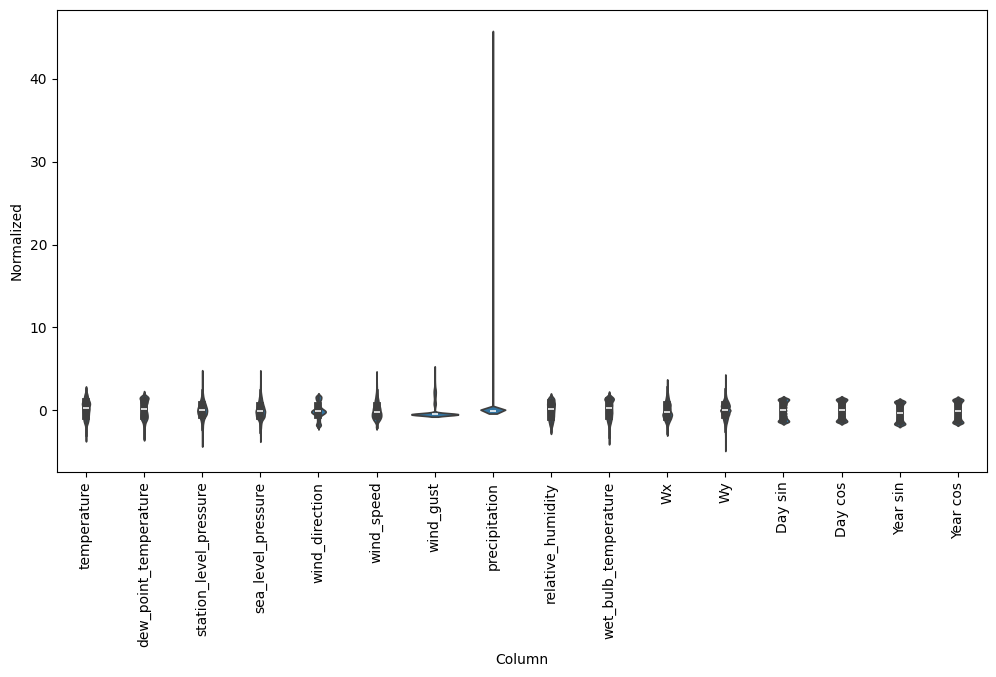

In [134]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [135]:
# Get the top 10 rows with the highest 'precipitation' values
top_10_precipitation = df.nlargest(10, 'precipitation')
print(top_10_precipitation)


                     temperature  dew_point_temperature  \
Datetime                                                  
2016-04-16 13:00:00    12.600000              12.116667   
2015-06-12 08:00:00    15.800000              15.600000   
2016-07-03 02:00:00    20.383333              19.233333   
2016-08-07 07:00:00    19.550000              18.700000   
2016-07-02 07:00:00    18.180000              18.180000   
2015-05-28 02:00:00    17.500000              15.000000   
2015-05-25 07:00:00    12.375000              10.062500   
2015-05-25 05:00:00    12.683333              11.616667   
2015-05-17 00:00:00    12.516667              10.483333   
2016-05-24 23:00:00    22.325000              20.750000   

                     station_level_pressure  sea_level_pressure  \
Datetime                                                          
2016-04-16 13:00:00              918.000000         1006.906667   
2015-06-12 08:00:00              921.480000         1009.806667   
2016-07-03 02:00:00    